In [1]:
import os
from scipy.linalg import svd 
from IPython.core.display import SVG
import pyomo.environ as pyo
import idaes
import pytest
import idaes.logger as idaeslog
from idaes.core.util.model_statistics import degrees_of_freedom as dof
import idaes.core.util.exceptions as idaes_except
from idaes.core.solvers import use_idaes_solver_configuration_defaults
import idaes.core.util.scaling as iscale
from soec import SoecStandaloneFlowsheet
from soec_flowsheet_costing import (
    get_solo_soec_capital_costing,
    initialize_flowsheet_costing,
    scale_flowsheet_costing,
    get_soec_OM_costing,
    display_soec_costing
)
import idaes.core.util.model_statistics as mstat
from idaes.models.properties import iapws95
from pyomo.util.check_units import assert_units_consistent
import idaes.core.util as iutil

import numpy as np
import pandas as pd

In [2]:
from pyomo.core.expr.current import identify_variables
from pyomo.common.collections import ComponentSet
def find_active_constraints_containing_variable(var, blk):
    con_set = ComponentSet()
    CUID = pyo.ComponentUID(var)
    for c in blk.component_data_objects(ctype=pyo.Constraint, active=True, descend_into=True):
        for v in identify_variables(c.body):
            if CUID.matches(v):
                con_set.add(c)
    return con_set

In [3]:
use_idaes_solver_configuration_defaults()
idaes.cfg.ipopt.options.nlp_scaling_method = "user-scaling"
idaes.cfg.ipopt.options.OF_ma57_automatic_scaling = "yes"
idaes.cfg.ipopt["options"]["linear_solver"] = "ma57"
idaes.cfg.ipopt["options"]["max_iter"] = 300
idaes.cfg.ipopt["options"]["halt_on_ampl_error"] = "no"

In [4]:
m = pyo.ConcreteModel()
m.fs = SoecStandaloneFlowsheet(dynamic=False)
iscale.calculate_scaling_factors(m)

2022-12-15 16:57:57 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_in[0.0].mole_frac_comp
2022-12-15 16:57:57 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_out[0.0].mole_frac_comp
2022-12-15 16:57:57 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_in[0.0].mole_frac_comp
2022-12-15 16:57:57 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_out[0.0].mole_frac_comp
2022-12-15 16:57:57 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash04.control_volume.properties_in[0.0].mole_frac_comp
2022-12-15 16:57:57 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash04.control_volume.properties_out[0.0].mole_frac_comp
2022-12-15 16:57:57 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flas

In [5]:
m.fs.initialize_build(outlvl=idaeslog.INFO_LOW)#, load_from="soec_standalone_init.json.gz")
# m.fs.initialize_build(outlvl=idaeslog.DEBUG)

WARNING (W1002): Setting Var 'fs.water_evaporator01.hot_side.properties_in[0.0
    ].log_mole_frac_tdew[Liq,Vap,H2O]' to a numeric value
    `4.403681862637669e-10` outside the bounds (None, 0).
    See also https://pyomo.readthedocs.io/en/latest/errors.html#w1002
WARNING (W1002): Setting Var 'fs.water_evaporator01.hot_side.properties_out[0.
    0].log_mole_frac_tdew[Liq,Vap,H2O]' to a numeric value
    `4.403681862637669e-10` outside the bounds (None, 0).
    See also https://pyomo.readthedocs.io/en/latest/errors.html#w1002
WARNING (W1002): Setting Var 'fs.water_preheater.hot_side.properties_in[0.0].l
    og_mole_frac_tdew[Liq,Vap,H2O]' to a numeric value `4.403681862637669e-10`
    outside the bounds (None, 0).
    See also https://pyomo.readthedocs.io/en/latest/errors.html#w1002
WARNING (W1002): Setting Var 'fs.water_preheater.hot_side.properties_out[0.0].
    log_mole_frac_tdew[Liq,Vap,H2O]' to a numeric value
    `4.403681862637669e-10` outside the bounds (None, 0).
    See also h

In [6]:
print(dof(m))
get_solo_soec_capital_costing(m.fs, CE_index_year="2018")
get_soec_OM_costing(m.fs)
print(dof(m))
iscale.calculate_scaling_factors(m)

0
0
2022-12-15 16:59:08 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_in[0.0].mole_frac_comp
2022-12-15 16:59:08 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_out[0.0].mole_frac_comp
2022-12-15 16:59:08 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_in[0.0].mole_frac_comp
2022-12-15 16:59:08 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_out[0.0].mole_frac_comp
2022-12-15 16:59:08 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash04.control_volume.properties_in[0.0].mole_frac_comp
2022-12-15 16:59:08 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash04.control_volume.properties_out[0.0].mole_frac_comp
2022-12-15 16:59:08 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_

In [7]:
solver = pyo.SolverFactory("ipopt")

In [8]:
initialize_flowsheet_costing(m.fs)
scale_flowsheet_costing(m.fs)

m.fs.tags_output["annual_water_cost"] = iutil.ModelTag(
    doc="Annual water cost",
    expr=m.fs.costing.annual_water_cost,
    format_string="{:.2f}",
)

In [9]:
assert dof(m) == 0
res = solver.solve(m, tee=True, options={"tol": 1e-6, "max_iter": 300, "halt_on_ampl_error":"no"})
assert res.solver.termination_condition == pyo.TerminationCondition.optimal
assert res.solver.status == pyo.SolverStatus.ok

Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=300
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmpbyqlgtb__ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmpbyqlgtb__ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All tec

In [10]:
def set_indexed_variable_bounds(var,bounds):
    for idx, subvar in var.items():
        subvar.bounds = bounds
if True:
    m.fs.obj = pyo.Objective(
        expr = (
            m.fs.costing.annual_electricity_cost 
            + m.fs.costing.annual_water_cost
            + m.fs.costing.total_annualized_cost
            + m.fs.costing.annual_fixed_operations_and_maintenance_cost
            + m.fs.costing.annual_air_cost
        )
    )
    
    m.fs.max_raw_water_withdrawal_eqn.deactivate()
    m.fs.feed_heater.max_heat_duty_eqn.deactivate()
    m.fs.sweep_heater.max_heat_duty_eqn.deactivate()
    m.fs.heat_pump.max_heat_duty_eqn.deactivate()
    
    m.fs.max_raw_water_withdrawal_ineq.activate()
    m.fs.feed_heater.max_heat_duty_ineq.activate()
    m.fs.sweep_heater.max_heat_duty_ineq.activate()
    m.fs.heat_pump.max_heat_duty_ineq.activate()
    
    for hx in [m.fs.feed_hot_exchanger, m.fs.sweep_hot_exchanger, m.fs.sweep_medium_exchanger,
              m.fs.water_evaporator01, m.fs.water_evaporator02, m.fs.water_evaporator03,
              m.fs.water_evaporator04, m.fs.water_evaporator05, m.fs.water_preheater]:
        set_indexed_variable_bounds(hx.delta_temperature_in, (0, None))
        set_indexed_variable_bounds(hx.delta_temperature_out, (0, None))
        hx.area.bounds = (400, None)
        hx.area.unfix()
    
    # I suspect there are several solutions close in price with areas portioned
    # differerently between evaporators. Fix these areas to (hopefully) force
    # IPOPT to just choose one
    m.fs.water_evaporator01.area.fix(2018)
    m.fs.water_evaporator04.area.fix(5245)
    
    @m.fs.Constraint(m.fs.time)
    def water_evaporator02_vapor_out_ineq(b,t):
        try:
            tdew = b.water_evaporator02.shell.properties_out[t].temperature_dew["Vap","Liq"]
        except KeyError:
            tdew = b.water_evaporator02.shell.properties_out[t].temperature_dew["Liq","Vap"]
        return (
            b.water_evaporator02.shell.properties_out[t].temperature 
            >= tdew
        )
#     @m.fs.Constraint(m.fs.time)
#     def water_evaporator03_vapor_out_ineq(b,t):
#         try:
#             tdew = b.water_evaporator03.shell.properties_out[t].temperature_dew["Vap","Liq"]
#         except KeyError:
#             tdew = b.water_evaporator03.shell.properties_out[t].temperature_dew["Liq","Vap"]
#         return (
#             b.water_evaporator03.shell.properties_out[t].temperature 
#             >= tdew
#         )
    iscale.constraint_scaling_transform(m.fs.water_evaporator02_vapor_out_ineq[0], 1e-2)
#     iscale.constraint_scaling_transform(m.fs.water_evaporator03_vapor_out_ineq[0], 1e-2)
    
    
    for cmp in [m.fs.sweep_blower, m.fs.cmp01, m.fs.cmp02, m.fs.cmp03, m.fs.cmp04]:
        set_indexed_variable_bounds(cmp.work_mechanical, (0, None))
    set_indexed_variable_bounds(m.fs.water_compressor.control_volume.work, (0, None))
    
    m.fs.h2_mass_production.fix(2)
    m.fs.water_preheater.tube_inlet.flow_mol.unfix()
    m.fs.soec_single_pass_water_conversion.unfix()
    m.fs.feed_recycle_split.split_fraction.unfix()
    m.fs.sweep_recycle_split.split_fraction.unfix()
    m.fs.sweep_blower.inlet.flow_mol.unfix()
    #m.fs.sweep_blower.control_volume.properties_out[:].pressure.unfix()
    m.fs.feed_heater.outlet.temperature.unfix()
    m.fs.sweep_heater.outlet.temperature.unfix()
    
    
    
    m.fs.soec_module.potential_cell.unfix()
    m.fs.soec_module.number_cells.unfix()
    m.fs.costing.electricity_price.fix(71.7)
    
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.potential, (1.1,1.6))
    set_indexed_variable_bounds(m.fs.water_split.split_fraction, (0.03,0.98))
    set_indexed_variable_bounds(m.fs.feed_heater.heat_duty,(0,None))
    set_indexed_variable_bounds(m.fs.sweep_heater.heat_duty,(0,None))
    set_indexed_variable_bounds(m.fs.heat_pump_hot_terminus.heat_duty, (0, None))
    set_indexed_variable_bounds(m.fs.sweep_blower.inlet.flow_mol,(1000,None))
    m.fs.feed_recycle_split.split_fraction[0,"recycle"].bounds = (0.03,0.5)
    m.fs.sweep_recycle_split.split_fraction[0,"recycle"].bounds = (0.03,0.5)
    set_indexed_variable_bounds(m.fs.soec_overall_water_conversion, (0.4,0.8))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.temperature_z, (550+273.15,750+273.15))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.fuel_channel.temperature_inlet, (600+273.15,750+273.15))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.oxygen_channel.temperature_inlet, (600+273.15,750+273.15))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.current_density, (-10400,5200))
    set_indexed_variable_bounds(m.fs.heat_source.inlet.flow_mol[0], (1, None))
    
    m.fs.feed_heater.max_heat_duty.set_value(8e6)
    m.fs.sweep_heater.max_heat_duty.set_value(8e6)
    m.fs.feed_heater.max_heat_duty.bounds = (8e6, None)
    m.fs.sweep_heater.max_heat_duty.bounds = (8e6, None)
    #m.fs.heat_pump.max_heat_duty.fix(2e7)
    m.fs.max_raw_water_withdrawal.fix(3000)
    
    for cmp in [m.fs.cmp01, m.fs.cmp02, m.fs.cmp03, m.fs.cmp04]:
        cmp.ratioP.unfix()
        set_indexed_variable_bounds(cmp.ratioP, (1, 3))
        set_indexed_variable_bounds(cmp.outlet.temperature, (273.15, 250+273.15))
    
    m.fs._make_temperature_gradient_terms()
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.fuel_electrode.dtemperature_dz, (-750, 750))
    m.fs.make_performance_constraints()
#     @m.fs.Constraint(m.fs.time)
#     def equal_pressures_eqn(b,t):
#        return b.soec_module.fuel_inlet.pressure[t] == b.soec_module.oxygen_inlet.pressure[t]
    
#     iscale.constraint_scaling_transform(m.fs.equal_pressures_eqn[0],1e-5)

    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in (or after) 7.0) (called from
    C:\Users\cptda\Work\examples-
    pse\src\Examples\Flowsheets\power_generation\soec\soec.py:1643)
    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in (or after) 7.0) (called from
    C:\Users\cptda\Work\examples-
    pse\src\Examples\Flowsheets\power_generation\soec\soec.py:1646)


In [11]:
m.fs.h2_mass_production.fix(5)
jac_unscaled, jac_scaled, nlp = iscale.constraint_autoscale_large_jac(m)
solver.solve(m, tee=True, options={"tol": 3e-8, "max_iter": 500, "halt_on_ampl_error":"no"})

Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=3e-08
linear_solver=ma57
max_iter=500
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmp_bix1oai_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmp_bix1oai_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All tec

  66  5.3236920e+02 3.43e-01 3.24e+11  -5.7 1.25e+01  -4.0 1.00e+00 1.57e-01h  1
  67  5.3235084e+02 4.25e-01 5.19e+10  -5.7 1.66e+02    -  5.38e-01 1.00e+00h  1
  68  5.3228615e+02 5.52e-01 7.53e+11  -5.7 1.57e+03    -  9.41e-01 1.23e-01h  1
  69  5.3234200e+02 2.77e-01 4.91e+10  -5.7 2.65e+01    -  7.58e-01 9.86e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  5.3235964e+02 2.73e-01 1.07e+12  -5.7 4.40e+01    -  7.48e-01 2.24e-01h  2
  71  5.3236778e+02 2.79e-01 2.34e+12  -5.7 2.83e+01    -  1.00e+00 8.03e-02h  2
  72  5.3236896e+02 2.78e-01 2.70e+12  -5.7 4.85e+01    -  9.30e-01 1.17e-02h  3
  73  5.3236912e+02 2.78e-01 2.78e+12  -5.7 1.56e+01    -  1.00e+00 1.27e-03h  9
  74  5.3246109e+02 4.38e-01 7.06e+11  -5.7 1.65e+01    -  9.98e-01 7.46e-01h  1
  75  5.3244376e+02 4.75e-01 5.73e+11  -5.7 1.92e+01    -  6.23e-01 7.92e-01h  1
  76  5.3248567e+02 4.43e-01 7.52e+12  -5.7 3.85e+01    -  9.04e-01 7.26e-02h  4
  77  5.3259980e+02 3.71e-01

 159r 5.3221742e+02 1.78e-01 1.00e+03  -0.7 0.00e+00  -2.2 0.00e+00 0.00e+00R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160r 5.3221765e+02 1.78e-01 9.99e+02  -0.7 2.18e+04    -  1.18e-04 5.73e-06f  1
 161r 5.3225643e+02 4.79e-02 1.01e+03  -0.7 7.58e+02    -  9.15e-04 1.22e-03f  1
 162r 5.3226132e+02 4.62e-02 9.87e+02  -0.7 4.12e+01    -  1.06e-02 2.08e-03f  1
 163r 5.3230159e+02 4.61e-02 9.58e+02  -0.7 2.48e+01    -  2.91e-02 1.34e-02f  1
 164r 5.3244109e+02 4.66e-02 9.14e+02  -0.7 3.02e+01    -  4.59e-02 4.82e-02f  1
 165r 5.3277011e+02 4.88e-02 8.22e+02  -0.7 2.43e+01    -  1.39e-01 1.25e-01f  1
 166r 5.3389537e+02 1.21e-01 4.52e+02  -0.7 2.08e+01    -  4.26e-01 4.95e-01f  1
 167r 5.3623724e+02 2.65e-01 1.43e+02  -0.7 1.01e+01    -  6.84e-01 1.00e+00f  1
 168r 5.3620950e+02 1.46e-02 1.30e+00  -0.7 3.19e+00    -  1.00e+00 1.00e+00f  1
 169r 5.3456493e+02 2.62e-02 1.11e+02  -2.2 1.68e+01    -  9.37e-01 5.50e-01f  1
iter    objective    inf_pr 

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2490, 'Number of variables': 2490, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 41.25166964530945}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [12]:
m.fs.soec_module.number_cells.pprint()
m.fs.soec_module.solid_oxide_cell.current_density.pprint()
print(pyo.value(m.fs.soec_module.solid_oxide_cell.average_current_density[0]))
print(pyo.value((m.fs.obj)*1e6/(5*m.fs.costing.plant_uptime)))

number_cells : Number of cells in SOC module
    Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 1087915.2961547659 :  None : False : False :  Reals
current_density : Size=10, Index=fs.soec_module.solid_oxide_cell.current_density_index, Units=A/m**2
    Key       : Lower  : Value               : Upper : Fixed : Stale : Domain
     (0.0, 1) : -10400 :  -8552.481100050432 :  5200 : False : False :  Reals
     (0.0, 2) : -10400 :  -9872.858860586894 :  5200 : False : False :  Reals
     (0.0, 3) : -10400 :            -10400.0 :  5200 : False : False :  Reals
     (0.0, 4) : -10400 : -10146.127664455396 :  5200 : False : False :  Reals
     (0.0, 5) : -10400 :   -9367.40314420472 :  5200 : False : False :  Reals
     (0.0, 6) : -10400 :   -8331.57872841982 :  5200 : False : False :  Reals
     (0.0, 7) : -10400 :  -7240.200662227903 :  5200 : False : False :  Reals
     (0.0, 8) : -10400 :   -6214.10885531122 :  5200 : False : Fa

In [13]:
display_soec_costing(m.fs)

Capital cost: $439M
Fixed O&M cost: $26.1M/yr
Electricity cost: $2.87/kg H2
Water cost: $0.01/kg H2
Air cost: $0.07/kg H2


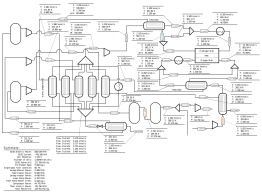

In [14]:
display(SVG(m.fs.write_pfd()))

In [15]:
streams_df = m.fs.streams_dataframe()
display(streams_df)

,mass flow (kg/s),mole flow (kmol/s),mole percent Ar (%),mole percent CO2 (%),mole percent H2 (%),mole percent H2O (%),mole percent N2 (%),mole percent O2 (%),pressure (bar),temperature (K),vapor fraction (%),volumetric flow (m**3/s)
feed01,55.850905,3.100198,NaN,NaN,NaN,100.0,NaN,NaN,1.2,489.184396,100.0,104.510707
feed02a,55.850905,3.100198,NaN,NaN,NaN,100.0,NaN,NaN,1.2,837.804027,100.0,179.843508
feed02b,55.850942,3.100198,NaN,NaN,0.0,100.0,NaN,NaN,1.2,837.804027,NaN,179.816147
feed03,72.020882,6.200397,NaN,NaN,40.000001,59.999999,NaN,NaN,1.2,893.356797,NaN,383.734354
feed04,72.020882,6.200397,NaN,NaN,40.000001,59.999999,NaN,NaN,1.2,929.128108,NaN,399.115451
hstrm01,32.33988,6.200397,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,962.166542,NaN,413.414798
hstrm02,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,962.166542,NaN,206.707403
hstrm03,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,962.166542,NaN,206.707395
hstrm04,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,546.975234,NaN,117.492387
hstrm05,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,372.220932,NaN,79.914997


In [16]:
m.fs.write_pfd(fname="soec_standalone_design_point.svg")
streams_df.to_csv("soec_standalone_design_point.csv")

In [17]:
water_heaters = [
    m.fs.water_evaporator01,
    m.fs.water_evaporator02,
    m.fs.water_evaporator03,
    m.fs.water_evaporator04,
    m.fs.water_evaporator05,
    m.fs.water_preheater,
]
cross_flow_exchangers = [
    m.fs.feed_hot_exchanger,
    m.fs.sweep_hot_exchanger,
    m.fs.sweep_medium_exchanger,
]
heaters = [
    m.fs.feed_heater,
    m.fs.sweep_heater
]
flash_vessels = [m.fs.product_flash01,
#                  m.fs.product_flash02,
                 m.fs.product_flash03,
                 m.fs.product_flash04,
                 m.fs.product_flash05,
                ]



compressors = [getattr(m.fs, f"cmp0{i}") for i in range(1,5)]
print(f"Total CapEx: ${pyo.value(m.fs.costing.total_TPC):.2f}MM")
print(f"Contribution from SOEC: ${pyo.value(m.fs.soec_module.costing.total_plant_cost):.2f}MM")
print(f"Contribution from H2 compressors: ${pyo.value(sum([cmp.costing.total_plant_cost for cmp in compressors])):.2f}MM")
print(f"Contribution from H2O compressor: ${pyo.value(m.fs.water_compressor.costing.total_plant_cost):.2f}MM")
print(f"Contribution from trim heaters: ${pyo.value(sum([heater.costing.total_plant_cost for heater in heaters])):.2f}MM")
print(f"Contribution from gas-gas exchangers: ${pyo.value(sum([hx.costing.total_plant_cost for hx in cross_flow_exchangers])):.2f}MM")
print(f"Contribution from gas-water exchangers: ${pyo.value(sum([hx.costing.total_plant_cost for hx in water_heaters])):.2f}MM")
print(f"Contribution from flash vessels: ${pyo.value(sum([flash.costing.total_plant_cost for flash in flash_vessels])):.2f}MM")
print(f"Contribution from heat pump: ${pyo.value(m.fs.heat_pump.costing.total_plant_cost):.2f}MM")
print(f"Contribution from sweep blower: ${pyo.value(m.fs.sweep_blower.costing.total_plant_cost):.2f}MM")
print(f"Contribution from water feed & treatment systems: ${pyo.value(m.fs.costing.water_systems_cost):.2f}MM")
print(f"Contribution from accessory electric equipment: ${pyo.value(m.fs.costing.accessory_electric_plant_cost):.2f}MM")
print(f"Contribution from instrumentation and controls: ${pyo.value(m.fs.costing.instrumentation_and_control_cost):.2f}MM")
print(f"Contribution from improvements to site: ${pyo.value(m.fs.costing.improvements_to_site_cost):.2f}MM")
print(f"Contribution from buildings and structures: ${pyo.value(m.fs.costing.buildings_and_structures_cost):.2f}MM")

print("\n")
print("------------------------------------------")
print("Fixed Costs for Optimized Design")
print("------------------------------------------")

assert pyo.value(m.fs.costing.total_TPC) == pytest.approx(439.4946977, rel=5e-3)
print(f"TPC = {pyo.value(m.fs.costing.total_TPC)}")
print(f"TASC = {pyo.value(m.fs.costing.total_as_spent_cost)}")
assert pyo.value(m.fs.costing.total_annualized_cost) == pytest.approx(41.0940, rel=5e-3)
print(f"Annualized TASC (MM$/yr) = {pyo.value(m.fs.costing.total_annualized_cost)}")

print("Fixed O&M Costs")
print(f"annual_op_labor (MM$/yr) = {pyo.value(m.fs.costing.annual_operating_labor_cost)}")
print(f"maint_labor (MM$/yr) = {pyo.value(m.fs.costing.maintenance_labor_cost)}")
print(f"maint_material (MM$/yr) = {pyo.value(m.fs.costing.maintenance_material_cost)}")
print(f"admin_labor (MM$/yr) = {pyo.value(m.fs.costing.admin_and_support_labor_cost)}")
print(f"prop_tax_ins (MM$/yr) = {pyo.value(m.fs.costing.property_tax_and_insurance_cost)}")
print(f"soec_replace (MM$/yr) = {pyo.value(m.fs.soec_module.costing.annual_soec_replacement_cost)}")
# total_fixed = annual_op_labor + maint_labor + maint_material + admin_labor + prop_tax_ins + soec_replace
print(f"Annualized Fixed O&M (MM$/year) = {pyo.value(m.fs.costing.annual_fixed_operations_and_maintenance_cost)}")
fixed_cost_per_h2 = pyo.value(
    m.fs.costing.total_annualized_cost
    + m.fs.costing.annual_fixed_operations_and_maintenance_cost
)/24/365.2425/5/60/60*1e6
print(f"Fixed ($/kg h2) = {fixed_cost_per_h2}")

print(f"Annual water cost MM$ {pyo.value(m.fs.costing.annual_water_cost)}")
print(f"water cost $/kg h2 {pyo.value(m.fs.costing.annual_water_cost)/24/365/5/60/60*1e6}")

Total CapEx: $439.49MM
Contribution from SOEC: $72.84MM
Contribution from H2 compressors: $25.80MM
Contribution from H2O compressor: $45.96MM
Contribution from trim heaters: $25.18MM
Contribution from gas-gas exchangers: $16.46MM
Contribution from gas-water exchangers: $32.88MM
Contribution from flash vessels: $0.57MM
Contribution from heat pump: $34.77MM
Contribution from sweep blower: $2.88MM
Contribution from water feed & treatment systems: $31.12MM
Contribution from accessory electric equipment: $93.02MM
Contribution from instrumentation and controls: $23.19MM
Contribution from improvements to site: $27.48MM
Contribution from buildings and structures: $7.34MM


------------------------------------------
Fixed Costs for Optimized Design
------------------------------------------
TPC = 439.49469774329776
TASC = 581.2449226064435
Annualized TASC (MM$/yr) = 41.094016028275554
Fixed O&M Costs
annual_op_labor (MM$/yr) = 2.7639945332999996
maint_labor (MM$/yr) = 3.340159702849063
maint_ma

In [18]:
assert m.fs.tags_output['total_electric_power_per_h2'].value == pytest.approx(143.951, rel=5e-3)
assert m.fs.tags_input['water_utilization'].value == pytest.approx(66.667, rel=5e-3)

In [19]:
print(m.fs.tags_output['total_electric_power_per_h2'].value)
print(m.fs.tags_input['water_utilization'].value)
m.fs.soec_module.number_cells.pprint()

143.95128428572983
66.66666763175792
number_cells : Number of cells in SOC module
    Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 1087915.2961547659 :  None : False : False :  Reals


In [20]:
for hx in water_heaters + cross_flow_exchangers:
    print(f"{hx.name}: {pyo.value(hx.area)}")

fs.water_evaporator01: 2018
fs.water_evaporator02: 1632.2888589891074
fs.water_evaporator03: 1513.8071515610766
fs.water_evaporator04: 5245
fs.water_evaporator05: 5267.2550355539215
fs.water_preheater: 1748.0433712076915
fs.feed_hot_exchanger: 4639.917490004179
fs.sweep_hot_exchanger: 5521.96525439696
fs.sweep_medium_exchanger: 8511.849248587425


In [21]:
for flash in flash_vessels:
    flash.diameter.fix()
    flash.length.fix()
    flash.length_diameter_heuristic.deactivate()
    flash.capacity_heuristic.deactivate()

for hx in water_heaters + cross_flow_exchangers:
    hx.area.fix()

for heater in heaters:
    heater.max_heat_duty.fix()
    
for blk in m.fs.block_data_objects():
    if hasattr(blk, "costing"):
        blk.costing.deactivate()

# Need the parent costing block for variable cost
m.fs.costing.activate()
m.fs.costing.total_TPC.fix()
m.fs.costing.total_TPC_eqn.deactivate()
    
m.fs.soec_module.number_cells.fix()
m.fs.max_raw_water_withdrawal.fix()
m.fs.heat_pump.max_heat_duty.fix()

m.fs.obj.deactivate()
m.fs.obj2 = pyo.Objective(
        expr = 0.1*(
            m.fs.costing.annual_electricity_cost 
            + m.fs.costing.annual_water_cost
            + m.fs.costing.annual_air_cost
        )
    )
m.fs.obj3 = pyo.Objective(
        expr = 10*(
            m.fs.costing.annual_electricity_cost 
            + m.fs.costing.annual_water_cost
            + m.fs.costing.annual_air_cost
        )
    )  
m.fs.obj3.deactivate()

In [22]:
run_samples = False
df = None
prod_vec = np.linspace(5, 1, 17)

if run_samples:
    i=1
    df = pd.DataFrame(columns=m.fs.tags_output.table_heading())
    for prod in prod_vec:
        print(prod)
        solved = False
        m.fs.obj2.activate()
        m.fs.obj3.deactivate()
        m.fs.h2_mass_production.fix(prod)
        res = solver.solve(m, tee=True, options={"tol": 1e-6, "max_iter": 250, "halt_on_ampl_error":"no"})
        solved = (res.solver.termination_condition == pyo.TerminationCondition.optimal
                  and res.solver.status == pyo.SolverStatus.ok)
        if not solved:
            m.fs.obj2.deactivate()
            m.fs.obj3.activate()
            res = solver.solve(m, tee=True, options={"tol": 1e-6, "max_iter": 250, "halt_on_ampl_error":"no"})
            assert res.solver.termination_condition == pyo.TerminationCondition.optimal
            assert res.solver.status == pyo.SolverStatus.ok
#             solved = (res.solver.termination_condition == pyo.TerminationCondition.optimal
#                       and res.solver.status == pyo.SolverStatus.ok)
#             if not solved:
#                 m.fs.obj3.deactivate()
#                 m.fs.obj4.activate()
#                 res = solver.solve(m, tee=True, options={"tol": 1e-6, "max_iter": 150, "halt_on_ampl_error":"no"})

        df.loc[i] = m.fs.tags_output.table_row(numeric=True)
        i += 1


In [23]:
if df is not None:
    df.to_csv("soec.csv")

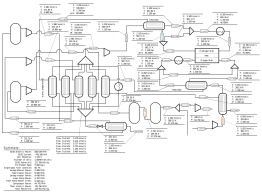

In [24]:
display(SVG(m.fs.write_pfd()))

In [25]:
for flash in [m.fs.product_flash01, 
              #m.fs.product_flash02,
              m.fs.product_flash03,
              m.fs.product_flash04,
              m.fs.product_flash05]:
    print(flash.name)
    print(f"Diameter: {flash.diameter.value}m")
    print(f"Height: {flash.length.value}m")
    print()

fs.product_flash01
Diameter: 1.0298536097008724m
Height: 3.089560829102617m

fs.product_flash03
Diameter: 0.014028412221900703m
Height: 0.04208523666570211m

fs.product_flash04
Diameter: 1.5932594469628905m
Height: 4.779778340888671m

fs.product_flash05
Diameter: 0.8206221637575413m
Height: 2.461866491272624m



In [26]:
from idaes.core.util.model_diagnostics import DegeneracyHunter
def check_scaling(blk):
    jac, nlp = iscale.get_jacobian(blk, scaled=True)
    # djac = jac.todense()
    # print("Extreme Jacobian entries:")
    # for i in iscale.extreme_jacobian_entries(jac=jac, nlp=nlp, large=1E3, small=0):
    #     print(f"    {i[0]:.2e}, [{i[1]}, {i[2]}]")
    print("Badly scaled variables:")
    for i in iscale.extreme_jacobian_columns(
            jac=jac, nlp=nlp, large=1E3, small=5E-3):
        print(f"    {i[0]:.2e}, [{i[1]}]")
    print("\n\n" + "Badly scaled constraints:")
    for i in iscale.extreme_jacobian_rows(
            jac=jac, nlp=nlp, large=1E3, small=5E-3):
        print(f"    {i[0]:.2e}, [{i[1]}]")
    #print(f"Jacobian Condition Number: {iscale.jacobian_cond(jac=jac):.2e}")

    if not hasattr(blk, "obj"):
        blk.obj = pyo.Objective(expr=0)
    dh = DegeneracyHunter(blk, solver=pyo.SolverFactory('cbc'))
    dh.check_rank_equality_constraints(dense=True)
    variables = nlp.get_pyomo_variables()
    constraints = nlp.get_pyomo_equality_constraints()
    # ds = dh.find_candidate_equations()
    for i in np.where(abs(dh.v[:, -1]) > 0.1)[0]:
        print(str(i) + ": " + variables[i].name)
    for i in np.where(abs(dh.u[:, -1]) > 0.1)[0]:
        print(str(i) + ": " + constraints[i].name)

    return (variables, constraints, jac, dh)

In [27]:
variables, constraints, jac, dh = check_scaling(m.fs)

Badly scaled variables:


Badly scaled constraints:

Checking rank of Jacobian of equality constraints...
Model contains 2357 equality constraints and 2366 variables.
Computing the 10 smallest singular value(s)
Smallest singular value(s):
9.904E-06
1.074E-05
1.193E-05
1.279E-05
1.324E-05
1.659E-05
4.561E-05
9.153E-05
1.248E-04
2.621E-04
150: fs.soec_module.solid_oxide_cell.fuel_channel.diff_eff_coeff[0.0,1,H2]
151: fs.soec_module.solid_oxide_cell.fuel_channel.diff_eff_coeff[0.0,1,H2O]
152: fs.soec_module.solid_oxide_cell.fuel_channel.diff_eff_coeff[0.0,2,H2]
153: fs.soec_module.solid_oxide_cell.fuel_channel.diff_eff_coeff[0.0,2,H2O]
154: fs.soec_module.solid_oxide_cell.fuel_channel.diff_eff_coeff[0.0,3,H2]
155: fs.soec_module.solid_oxide_cell.fuel_channel.diff_eff_coeff[0.0,3,H2O]
156: fs.soec_module.solid_oxide_cell.fuel_channel.diff_eff_coeff[0.0,4,H2]
157: fs.soec_module.solid_oxide_cell.fuel_channel.diff_eff_coeff[0.0,4,H2O]
158: fs.soec_module.solid_oxide_cell.fuel_channel.diff_ef